In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('./data/data_for_modelling.csv')

In [3]:
num_df = df.select_dtypes(exclude = 'object')

Log transform turns out to be most suitable for our distribution as the other two scaling methods failed to deal with outliers effectively 

In [4]:
num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)

<ipython-input-4-81ff5d350291>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['avg_yearly_sal'] = num_df['avg_yearly_sal'].apply(lambda x: np.log(x) if x>0 else 0)


Now our annual salary distribution is quite uniform

Lets do the train test split<br>
<b> Note </b> : Here we are using train test split as dataset is quite small but if you have a much bigger dataset you might want to consider using stratified shuffle split.<br>
In our case train test split gave better results compared to stratified shuffling

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(num_df.drop('avg_yearly_sal', axis=1), num_df['avg_yearly_sal'], test_size=100, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

lets load our trained models

In [7]:
RandomForest = pickle.load(open('./all_trained_models/rnd_best.sav', 'rb'))
ExtraTrees = pickle.load(open('./all_trained_models/Extra_best.sav', 'rb'))
GB_tree = pickle.load(open('./all_trained_models/GB_best.sav', 'rb'))
VotingRegTree = pickle.load(open('./all_trained_models/Voting_best.sav', 'rb'))
XGB = pickle.load(open('./all_trained_models/xgr_best.sav', 'rb'))
dtree = pickle.load(open('./all_trained_models/DecisionTree.sav', 'rb'))
lasso_best = pickle.load(open('./all_trained_models/lasso_best.sav', 'rb'))
svr_best = pickle.load(open('./all_trained_models/svr_best.sav', 'rb'))

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
rnd_reg = RandomForestRegressor(oob_score=True, random_state=42)
rnd_reg.fit(X_train , y_train)

RandomForestRegressor(oob_score=True, random_state=42)

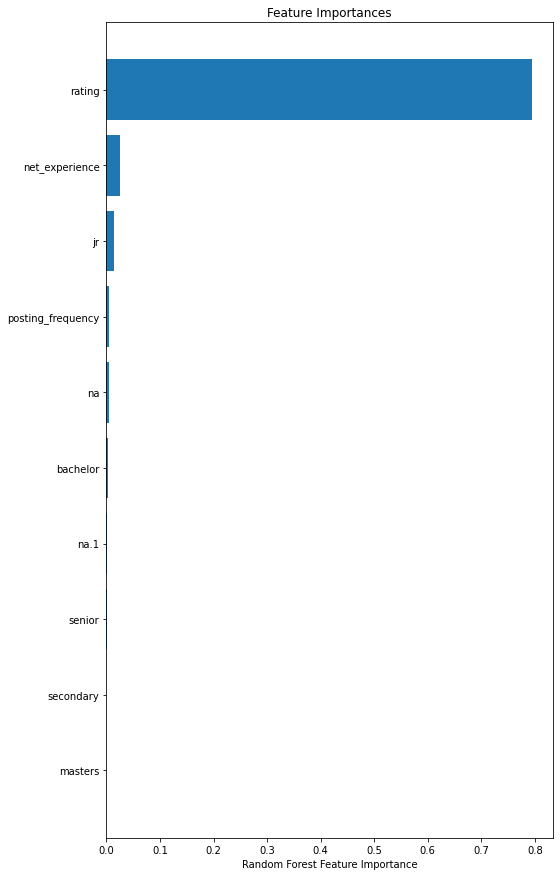

In [10]:
# plot to see top 10 important features by random forest
col_names = num_df.drop('avg_yearly_sal', axis=1).columns
plt.figure(figsize=(8,15))
importances = rnd_reg.feature_importances_ [:10]
idxs = np.argsort(importances) 
plt.title('Feature Importances') 
plt.barh(range(len(idxs)), importances[idxs], align='center') 
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs]) 
plt.xlabel('Random Forest Feature Importance') 
plt.show() 

In [11]:
from sklearn.metrics import mean_squared_error

In [32]:
pred = RandomForest.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

218930.32932706774

In [13]:
# our trained Lasso model
pred = lasso_best.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

667868.1282419725

In [14]:
# our trained SVR model
pred = svr_best.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

683731.0558101978

In [15]:
# our trained DecisionTree model
pred = dtree.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

284506.71476902196

In [16]:
# our trained XGBoost model
pred = XGB.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

247804.98303959318

In [17]:
# our trained ExtraTrees model
pred = ExtraTrees.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

318502.1933234396

In [18]:
# our trained GradientBoosted model
pred = GB_tree.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

469119.4293412239

Now using Voting regressor trained on the best performing models so far, which averages the individual prediction to form a final prediction.

In [19]:
pred = VotingRegTree.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

290991.8282563451

We can see that we have used some really powerful models like <b>Random forest</b>, <b>ExtraTrees</b>, <b>Gradient boosted trees</b> and <b>Xgboost</b> models as the complexity of problem is high but the available data is small.<br>
Thats why we also created a blender of best models so far, to squeeze a bit more performance from our models

In [20]:
# models to use in our blender 
estimators = [RandomForest, XGB, VotingRegTree, dtree, ExtraTrees, GB_tree]

In [21]:
X_train_predictions = np.empty((len(X_train), len(estimators)), dtype = np.float32)

In [22]:
for index, estimator in enumerate(estimators):
    X_train_predictions[:, index] = estimator.predict(X_train)

In [23]:
rnd_reg1 = RandomForestRegressor(n_estimators=100,oob_score=True, random_state=42)

In [24]:
rnd_reg1.fit(X_train_predictions, y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [25]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype = np.float32)

In [26]:
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [27]:
pred = rnd_reg1.predict(X_test_predictions)

In [28]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

233073.62050284116

In [29]:
from sklearn.metrics import r2_score

In [33]:
r2_score(y_test, pred)

0.7513094056097807

Our model explains about 3/4 th of the observed variation, which is great.   <br>
We can also conclude that the model can give much better predictions if fed with more data.

Here our tuned RandomForest performs slightly better than our ensemble

In [34]:
# calculate 95 percent confidence interval for our predictions
from scipy import stats
confidence = 0.95
squared_errors = (np.exp(pred) - np.exp(y_test)) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                        loc=squared_errors.mean(), 
                        scale=stats.sem(squared_errors))) 

array([113283.57770194, 288145.46538435])